## License Information

---

This file is distributed as part of _swprepost_, a Python package for surface wave inversion pre- and post-processing.

    Copyright (C) 2019-2022 Joseph P. Vantassel (jvantassel@utexas.edu)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.

## About SWinvert, _swprepost_, _swbatch_, and this notebook

---

[SWinvert](https://doi.org/10.1093/gji/ggaa426) is a workflow for performing
rigorous 1-D surface wave inversion (Vantassel and Cox, 2021).
[_swprepost_](https://github.com/jpvantassel/swprepost/) is a Python package for
performing surface wave inversion pre- and post-processing (Vantassel, 2020).
[_swbatch_](https://github.com/jpvantassel/swbatch) is an application on the
[DesignSafe-CI](https://www.designsafe-ci.org/) (Vantassel et al., 2020) which
allows users to perform batch-style surface wave inversions on the high
performance cluster Stampede2 or Frontera directly from Jupyter or through
the web interface.

This notebook is an example of a workflow that can be built using the
concepts from SWinvert and the tools _swprepost_ and _swbatch_.
The SWinvert workflow, _swprepost_, _swbatch_, and this notebook were
initially developed by Joseph P. Vantassel under the supervision of Professor
Brady R. Cox at The University of Texas at Austin. The package continues to be
developed by Joseph P. Vantassel. If you use this notebook in your research or
consulting we ask that you please cite the following:

> Vantassel, J.P. and Cox, B.R. (2021). SWinvert: a workflow for performing
> rigorous 1-D surface wave inversions. Geophysical Journal International
> 224, 1141-1156. https://doi.org/10.1093/gji/ggaa426

> Vantassel, J., (2020). jpvantassel/swprepost: latest (Concept). Zenodo. https://doi.org/10.5281/zenodo.3839998

> Vantassel, J., Gurram, H., and Cox, B., (2020). jpvantassel/swbatch: latest (Concept). Zenodo. https://doi.org/10.5281/zenodo.3840546

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for `swprepost` and `swbatch`, please use the citation tool
on the `swprepost` [archive](https://doi.org/10.5281/zenodo.3839998) and the
`swbatch` [archive](https://doi.org/10.5281/zenodo.3840545)._

## Using this notebook

This notebook has four main parts:

1. [Defining the inversion target](#Defining-the-Inversion-Target)
2. [Selecting the inversion parameterizations](#Selecting-the-Inversion-Parameterizations)
3. [Running the inversion](#Running-the-Inversion)
4. [Post-processing the inversion results](#Post-processing-the-Inversion-Results)

While the below workflow proposes a relatively straightforward and
production-tested approach to surface wave inversion, please feel free to modify
and expand upon what is provided. If you have implemented something that you believe
would be of interest to other users please open an issue on GitHub
detailing the new feature and then providing your implementation.
Note that this notebook utilizes only a fraction of the functionality available from the _swprepost_
package, therefore it is strongly recommended that you study the project's
documentation prior to implementing a new feature to be sure it does not already exist.

## An important final note

This notebook is intended as a tool to expedite surface wave inversion, however
it is of paramount importance that the user have some working knowledge of
surface wave inversion to understand what they are doing. __We strongly recommend
that this notebook not be used as "black-box" for surface wave inversion.__ At a
minimum we recommend the user read Vantassel and Cox (2021), citation above,
to familiarize themselves with the basics of surface wave inversion and the
specific recommendations presented therein.


## Install _swprepost_ and Dependencies

This will install _swprepost_ if you have not done so already. You will need to restart your Jupyter kernel after running the cell below for Python to be able to "see" the new installation.


In [ ]:
!pip install --user swprepost

## Imports and Function Definitions

In [3]:
import glob, re, os

import numpy as np
import matplotlib.pyplot as plt

import swprepost

def plot_target(target):
    fig, axs = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(6, 3), dpi=150)
    target.plot(x="frequency", y="velocity", ax=axs[0])
    target.plot(x="wavelength", y="velocity", ax=axs[1])
    axs[1].set_ylabel("")
    axs[1].legend()
    return (fig, axs)

print("Imports successful, you may proceed.")

Imports successful, you may proceed.


# Defining the Inversion Target

## Importing the Experimental Dispersion Data

1. Select the desired approach by commenting/uncommenting the appropriate line in the cell below.
2. Review the figure to ensure your data has loaded correctly, then proceed to the next cell.

[Back to top](#License-Information)

Import successful, you may proceed.


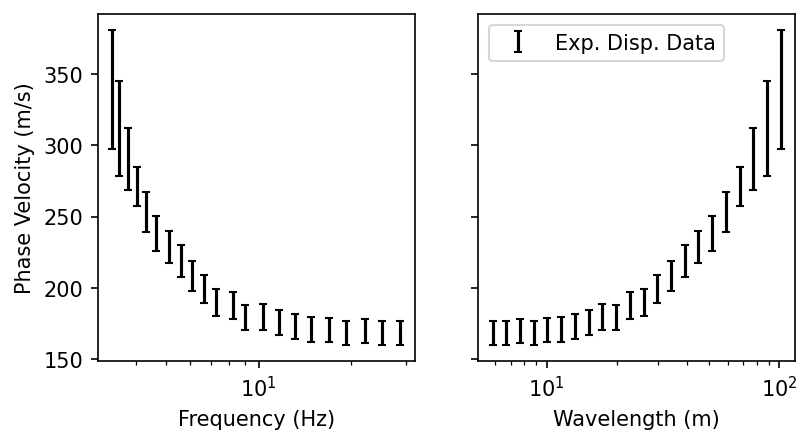

In [4]:
# Approach 1: Import from comma seperated text file (see swprepost documentation for details).
#target = swprepost.Target.from_csv("example.csv")

# Approach 2: Import from version 2.X.X dinver-style text file (see swprepost documentation for details).
# target = swprepost.Target.from_txt_dinver("example_dv2.txt", version="2")

# Approach 3: Import from version 3.X.X dinver-style text file (see swprepost documentation for details).
target = swprepost.Target.from_txt_dinver("CUSSO_masw&mam_R0_disp_stats.txt", version="3.4.2")


fig, axs = plot_target(target)
print("Import successful, you may proceed.")

## Resampling the Experimental Dispersion Data (Optional)

If you have not yet resample your experimental dispersion data, follow the
instructions below, otherwise, you may skip this cell.

1. Select the `domain` in which you wish to resample. _wavelength is recommended._
2. Select the `res_type` either log or linear. _log is recommended._
3. Select the minimum (`pmin`), maximum (`pmax`), and number of points (`pn`) after resampling. Note that `pmin` and `pmax` are in terms of the selected `domain` (i.e., either frequency or wavelength). _20-30 points are recommended._
4. Execute the cell and review the figure to ensure your data has been resampled correctly, then proceed to the next cell.

[Back to top](#License-Information)

In [ ]:
domain = "wavelength"       # "frequency" or "wavelength", "wavelength" is recommended
res_type = "log"            # "log" or 'linear', "log" is recommended.
pmin = 2                    # Minimum value after resampling in units of domain
pmax = 150                  # Maximum value after resampling in units of domain
pn = 20                     # Number of samples, 20-30 points are recommended.


target.easy_resample(pmin=pmin, pmax=pmax, pn=pn, res_type=res_type, domain=domain, inplace=True)
fig, axs = plot_target(target)
print("Resample successful, you may proceed.")

## Save Target to Disk

After importing your experimental dispersion data and completing any desired
resampling, use the cell below to create the `0_targets` directory (if
it does not exist) and write your `.target` file. You
can confirm that the write was sucessful by examining the created `.target`
file using the Dinver graphical user interface.


In [ ]:
target_name = "tar5"        # Name of target file (no .target suffix)
version = "3.4.2"           # Version of Geopsy "2.10.1" or "3.4.2"


# Save to Disk
if os.path.isdir("0_targets/")==False:
    os.mkdir("0_targets/")
target.to_target(f"0_targets/{target_name}", version=version)

# Confirm file exists.
if os.path.exists(f"0_targets/{target_name}.target"):
    print(f"{target_name}.target exists, you may proceed.")

## Selecting the Inversion Parameterizations

1. Enter upper and lower limits for all layers: compression wave velocity `vp`,
shear wave velocity `vs`, Poisson's ratio `pr`, and mass density `rh`. `vp` and
`vs` are in units of `m/s` and `rh` in units of `kg/m**3`.
2. Select whether you will allow `vp` and `vs` to decrease with depth
(inverely dispersive) or to be strictly increasing (normally dispersive). In
general unless there is clear evidence in the experimental dispersion data or
geologic setting that a velocity reversal exists, the normally dispersive
assumption is recommended.
3. Select the Layering by Number `LN` and/or Layering Ratio `LR`
parameterizations you would like to consider in your inversion. Note that this
notebook assumes `vp` and `vs` follow the same underlying layering scheme. This
may or may not be ideal for your specific data, however we have found this
type of parameterization works well in many situations. Only a
single layer is assumed for `pr` and `rh`.
4. After making your selections, run the cell to write the parameterizations
to disk. A `1_parameters` directory will be created if one does not exist for
storing the `*.param` files. If you would like to create more complex
parameterizations you may use the additional functionality of _swprepost_
(see documentation for details) or the Dinver graphical user interface.

__Be cautious when making your selections as they can strongly bias your inversion results.__

[Back to top](#License-Information)

In [ ]:
# Minimum and maximum for all parameters. Refer to detailed instructions above.
vp_min, vp_max, vp_dec = 100., 5000., False
vs_min, vs_max, vs_dec = 80., 3500., False
pr_min, pr_max = 0.2, 0.5
rh_min, rh_max = 2000., 2000.

# Layering by Number (LN) parameterizations to consider. Add or remove as desired.
# See Vantassel and Cox (2021) for details.
lns = [3, 4, 5]

# Layering Ratios (LRs) parameterizations to consider. Add or remove as desired.
# See Vantassel and Cox (2021) and Cox and Teague (2016) for details.
lrs = [3.0, 2.0, 1.5]

# Depth factor, typically 2 or 3.
depth_factor = 2

# Minimum and maximum wavelength, selected from experimental disperison data by default.
wmin, wmax = min(target.wavelength), max(target.wavelength)


# Mass density.
if (rh_min - rh_max) < 1:
    rh = swprepost.Parameter.from_fx(rh_min)
else:
    rh = swprepost.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=1, par_min=rh_min, par_max=rh_max, par_rev=False)
    
# Poisson's ratio
if (pr_max - pr_min) < 0.05:
    raise ValueError(f"Difference between pr_min and pr_max is too small ({pr_max-pr_min:2f}<0.05), use larger range.")
else:
    pr = swprepost.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=1, par_min=pr_min, par_max=pr_max, par_rev=False)

# Make 1_parameters directory.
if not os.path.isdir("1_parameters/"):
    os.mkdir("1_parameters/")

# Parameterize Vs using Layering by Number (LN)
for ln in lns:
    vs = swprepost.Parameter.from_ln(wmin=wmin, wmax=wmax, nlayers=ln, par_min=vs_min, par_max=vs_max, par_rev=vs_dec, depth_factor=depth_factor)
    vp = swprepost.Parameter.from_parameter_and_link(par_min=vp_min, par_max=vp_max, par_rev=vp_dec, existing_parameter=vs, ptype="vs")
    par = swprepost.Parameterization(vp=vp, pr=pr, vs=vs, rh=rh)
    par.to_param(f"1_parameters/ln{ln}", version=version)

# Parameterize Vs using Layering Ratio (LR)
for lr in lrs:
    vs = swprepost.Parameter.from_lr(wmin=wmin, wmax=wmax, lr=lr, par_min=vs_min, par_max=vs_max, par_rev=vs_dec, depth_factor=depth_factor)
    vp = swprepost.Parameter.from_parameter_and_link(par_min=vp_min, par_max=vp_max, par_rev=vp_dec, existing_parameter=vs, ptype="vs")
    par = swprepost.Parameterization(vp=vp, pr=pr, vs=vs, rh=rh)
    par.to_param(f"1_parameters/lr{int(lr*10)}", version=version)

nparam = len(lns) + len(lrs)
if len(glob.glob("1_parameters/*.param")) == nparam:
    print(f"All {nparam} .param files exist, you may proceed.")

## Running the Inversion

There are two ways to run your inversion(s):

1. Locally using the `.target` and `.param` files from above. (Not Recommended, for reasons provided below)
2. Remotely using the DesignSafe-CI application _swbatch_. (Recommended)

See the appropriate section below for instructions.

### If running locally

Running locally is generally not recommended as the DesignSafe-CI
application _swbatch_ has been specifically designed to integrate with the
inputs generated by this notebook. However, as some will undoubtedly still want
to run their inversion's locally instructions are provided below.

1. Load the `.target` and `.param` files into Dinver. The `.target` and `.param`
files are located in the `0_targets` and `1_parameters` directories,
respectively.
2. Setup the inversion's tuning parameters. Full details are provided in
Vantassel and Cox (2021), however for completeness a brief summary is provided
here. Number of independent runs (i.e., Ntrial) should be greater than 3,
It*Ns > 50,000 (e.g., It=200, Ns=250), Nr ~= 100, Ns0>Nr (e.g., Ns0=10000).
3. After completing your inversions export the desired number of ground models
and dispersion curves to text format, using the _geopsy_ command line interface.
Refer to the provided sample outputs in the `3_text` directory for the naming
conventions assumed by this notebook in order to be able to use the
post-processing provided below.

### If running remotely on DesignSafe-CI

This functionality is only available to those running this notebook through the [DesignSafe-CI's JupyterHub](https://jupyter.designsafe-ci.org).

1. Read through the first cell below and select your inversion tuning parameters.
2. When done, run the cell and inspect the output.
3. If there is an issue edit the cell and run it again.
4. Run the second cell below to launch your inversion on a high performance computing resource at the Texas Advanced Computing Center. Please only run this cell once.
5. Monitor the progress of your inversion by navigating to `Workspace > Tools & Application > Job Status`.

[Back to top](#License-Information)

In [ ]:
# Inversion Setup
# ---------------

# Analysis name that is brief, memorable, and descriptive.
# Each output file will begin with this string of characters.
# No spaces or special characters are permitted.
analysis_name = "example"          

# Number (positive integer) of inversion trials to perform
# per parameterization. (3 is recommended)
number_of_inversion_trials = 3

# Number (positive integer) of Neighborhood-Algorithm iterations
# to perform per inversion. (250 is recommended)
number_of_iterations = 250

# Number (positive integer) of randomly sampled profiles to attempt
# before the first Neighborhood-Algorithm iteration. (10000 is recommended)
number_of_initial_random_samples = 10000

# Number (positive integer) of best profiles to consider when
# resampling. (100 is recommended)
number_of_profiles_to_consider_when_resampling = 100

# Number (positive integer) of new profiles to consider per
# Neighborhood-Algorithm iteration. (200 is recommended)
number_of_profiles_per_iteration = 200

# Results to Export
# -----------------

# Number of ground models/dispersion curves/ellipticity curves to export
number_of_models_to_export = 100

# Number (positive integer) of Rayleigh and Love wave modes to export.
# If no dispersion curves are desired set both the number of Rayleigh and
# Love modes to 0. (1 is recommended)
number_of_rayleigh_modes_to_export = 1
number_of_love_modes_to_export = 0

# Number (positive float) for minimum amd maximum frequency of exported
# dispersion curve(s) in Hz. Selecting a value slightly less than the
# minimum frequency and a value slighlty greater than the maximum frequency
# of your experimental dispersion data is recommended.
minimum_dispersion_frequency = 1.
maximum_dispersion_frequency = 60.

# Number (positive integer) of frequency points in the exported dispersion
# curve(s). (30 is recommended)
number_of_dispersion_frequency_points = 30

# Number (positive integer) of Rayleigh modes to include in exported ellipticity.
# If no ellipticity curves are desired set this value to 0. (1 is recommended)
number_of_rayleigh_ellipticity_modes_to_export = 0

# Number (positive float) for minimum amd maximum frequency of exported
# Rayleigh wave ellipticity curve(s) in Hz. Selecting a value less than and
# greater than the site's resonant frequency is recommended.
minimum_ellipticity_frequency = 0.2
maximum_ellipticity_frequency = 20.

# Number (positive integer) of frequency points in exported Rayleigh wave
# ellipticity curve(s). (64 is recommended)
number_of_ellipticity_frequency_points = 64


# Job Details
# ---------------

# A recognizable name for this job.
# Name is used solely by DesignSafe-CI & AGAVE/TAPIS.
job_name = "example"

# Maximum job runtime in (HH:MM:SS) format.
# If this time is exceeded the job will be canceled by the job scheduler.
# Each queue has its own associated maximum time, typically 48 hours.
# See Stampede2 (if using Geopsy v2.10.1) or Frontera (if using Geopsy 3.4.2) for queue-specfic details.
runtime = "24:00:00"

# Changes are not required below this line
# ----------------------------------------

# Handle different agave import syntax.
try:
    old_agave = True
    from agavepy.agave import Agave
except SyntaxError:
    old_agave = False
    from agavepy import Agave
ag=Agave.restore()

full=os.getcwd()
left, right = full[:21], full[20:]
usr=ag.profiles.get()["username"]
if left != "/home/jupyter/MyData/":
    msg = f"Unexpected file structure. Expected '/home/jupyter/MyData/' found '{left}'"
    msg += calling_card
    raise ValueError(msg)

def find_latest_appid(app_prefix, apps=ag.apps.list()):
    for app in apps:
        appid = app["id"]
        if appid.startswith(app_prefix) and app["isPublic"]:
            break
    else:
        appid = app_prefix 
    return appid

sint = lambda x: str(int(x))    
soat = lambda x: str(float(x))

# Queue where job will be submitted.
if version == "2.10.1":
    # See Stampede2 documentation for details on the queues available.
    # The normal queue is recommended.
    batch_queue = "normal"

    # Find latest appID associated with swbatch v0.3.0.
    appId = find_latest_appid("swbatch-0.3.1")
    
    # Assemble job description
    job_description = {
    "name":job_name,
    "appId":appId,
    "batchQueue":batch_queue,
    "nodeCount":1,
    "maxRunTime":runtime,
    "archive":True,
    "inputs":{
        "workingdirectory":"agave://designsafe.storage.default/"+usr+right
    },
    "parameters":{
      "name":analysis_name,
      "ntrial":sint(number_of_inversion_trials),
      "ns0":sint(number_of_initial_random_samples),
      "it":sint(number_of_iterations),
      "ns":sint(number_of_profiles_per_iteration),
      "nr":sint(number_of_profiles_to_consider_when_resampling),
      "nmodels":sint(number_of_models_to_export),
      "nrayleigh":sint(number_of_rayleigh_modes_to_export),
      "nlove":sint(number_of_love_modes_to_export),
      "dcfmin":soat(minimum_dispersion_frequency),
      "dcfmax":soat(maximum_dispersion_frequency),
      "dcfnum":sint(number_of_dispersion_frequency_points),
      "nellipticity":sint(number_of_rayleigh_ellipticity_modes_to_export),
      "ellfmin":soat(minimum_ellipticity_frequency),
      "ellfmax":soat(maximum_ellipticity_frequency),
      "ellfnum":sint(number_of_ellipticity_frequency_points),
        }
    }
    
elif version == "3.4.2":
    # swbatch can only be run on Frontera's small queue.
    batch_queue = "small"
    
    # Find latest appID associated with swbatch v0.4.0.
    appId = find_latest_appid("swbatch-0.4.0")

    # Assemble job description
    job_description = {
    "name":job_name,
    "appId":appId,
    "batchQueue":batch_queue,
    "nodeCount":1,
    "maxRunTime":runtime,
    "archive":True,
    "inputs":{
        "workingdirectory":"agave://designsafe.storage.default/"+usr+right
    },
    "parameters":{
      "name":analysis_name,
      "ntrial":sint(number_of_inversion_trials),
      "ns0":sint(number_of_initial_random_samples),
      "ns":sint(number_of_profiles_per_iteration * number_of_iterations),
      "nr":sint(number_of_profiles_to_consider_when_resampling),
      "nmodels":sint(number_of_models_to_export),
      "nrayleigh":sint(number_of_rayleigh_modes_to_export),
      "nlove":sint(number_of_love_modes_to_export),
      "dcfmin":soat(minimum_dispersion_frequency),
      "dcfmax":soat(maximum_dispersion_frequency),
      "dcfnum":sint(number_of_dispersion_frequency_points),
      "nellipticity":sint(number_of_rayleigh_ellipticity_modes_to_export),
      "ellfmin":soat(minimum_ellipticity_frequency),
      "ellfmax":soat(maximum_ellipticity_frequency),
      "ellfnum":sint(number_of_ellipticity_frequency_points),
        }
    }

else:
    raise NotImplementedError("Only Geopsy versions, '2.10.1' and '3.4.2' are supported.")

calling_card = " Please submit a ticket on DesigSafe-CI and cc the developer Joseph P. Vantassel (joseph.p.vantassel@gmail.com)."
try:
    ag.apps.get(appId=appId)
except:
    msg = f"The DesignSafe-CI application swbatch appId={appId} could not be found."
    msg += calling_card
    raise ValueError(msg)

print("Confirm job information before continuing: ")
display(job_description)

In [ ]:
# Run cell to launch simulation. Please only run once.
job = ag.jobs.submit(body=job_description)

print("Job launched, check in Workspace > Tools & Application > Job Status to see if it was successful.")

## Post-processing the Inversion Results

### Importing the Data

In order for the data to import correctly you must provide a relative or full path to the `3_text` directory.

1. For those running this as a tutorial, no changes are necessary here.
2. For those running this locally, it is recommended you follow the same directory structure provided in the example, and therefore no changes are necessary.
3. For those running this remotely on DesignSafe-CI, you will need to replace the `full_path` variable in the cell below with the full path to the `3_text` directory containing your results. For your convenience, an incomplete `full_path` variable is provided below and commented out. To complete the path you will need to replace `<path_here>` with the actual path. The easiest way to find the full path to your data is by using the Job Status viewer by selecting `Workspace > Tools & Application > Job Status > <Your Job> > More Info > View` which will bring you to your job results. Alternatively, you can move the `3_text` directory form the job archive into the current directory, in which case no changes to `full_path` are necessary.

[Back to top](#License-Information)

['tar1_lv4_tr0_dc.txt', 'tar1_lv4_tr1_dc.txt', 'tar1_lv4_tr2_dc.txt']


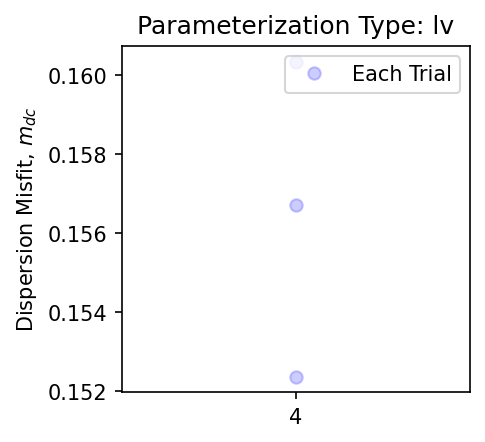

In [9]:
ndc = 100           # Number of dispersion curves to import, may use "all".
nrayleigh = 1       # Number of Rayleigh modes to import, may use "all".
nlove = 0           # Number of love modes to import, may use "all".
ngm = 100           # Number of ground models to import, may use "all".

full_path = "./3_text/"
# full_path = "/home/jupyter/MyData/archive/<path_here>/3_text/"

fnames = glob.glob(full_path + "*_[dD][cC].txt")
fnames = [fname[len(full_path):] for fname in fnames]
print(fnames)
fnames.sort(key=lambda x: int(re.findall(r".*l[v](\d+)_tr?\d+_dc.txt", x.lower())[0]))

dcs, gms = {}, {}
for fname in fnames:
    partype, parnumber, seed = re.findall(r".*(l[v])(\d+)_tr?(\d+)_dc.txt$", fname.lower())[0]
    fname = full_path + fname
    
    # Divide LR by 10
    if partype in ['lr']:
        parnumber = str(int(parnumber)/10)
    
    # Save by parameterization
    if partype not in dcs.keys():
        dcs.update({partype:{}})
        gms.update({partype:{}})
        firstpass = True
        
    # Save by parameterization number        
    if parnumber not in dcs[partype].keys():
        dcs[partype].update({parnumber:{}})
        gms[partype].update({parnumber:{}})
        
    # Save by trial
    if os.path.getsize(fname) == 0:
        print(f"fname = {fname}, is empty skipping!")
    else:
        dcs[partype][parnumber].update({seed:swprepost.DispersionSuite.from_geopsy(fname=fname, nsets=ndc, 
                                                                                   nrayleigh=nrayleigh, nlove=nlove)})
        try:
            gms[partype][parnumber].update({seed:swprepost.GroundModelSuite.from_geopsy(fname=fname[:-6]+"GM.txt", nmodels=ngm)})
        except FileNotFoundError:
            gms[partype][parnumber].update({seed:swprepost.GroundModelSuite.from_geopsy(fname=fname[:-6]+"gm.txt", nmodels=ngm)})

ncols = len(list(dcs.keys()))
fig, axs = plt.subplots(nrows=1, ncols=ncols, sharey=True, figsize=(3*ncols,3), dpi=150)
axs = [axs] if type(axs) != np.ndarray else axs
bestseed = {}
blabel = "Each Trial"
fiter = True
for ax, partype in zip(axs, dcs):
    bestseed.update({partype:{}})
    for parnumber in dcs[partype]:
        seeds, misfits = [], []
        for seed in dcs[partype][parnumber].keys():
            seeds.append(seed)
            misfits.append(dcs[partype][parnumber][seed].misfits[0])
            ax.plot(parnumber, misfits[-1], 'bo', label=blabel, alpha=0.2)
            blabel = None
        bestseed[partype].update({parnumber:seeds[misfits.index(min(misfits))]})
    if fiter:
        fiter = False
        ax.legend()
    ax.set_title("Parameterization Type: "+partype)
axs[0].set_ylabel("Dispersion Misfit, "+"$m_{dc}$")
plt.show()

### General Settings

_Note: If you are considering more than six parameterizations, you must provide additional colors in the list below._

[Back to top](#License-Information)

In [10]:
colors = ["tomato", "orange", "gold", "lightgreen", "skyblue", "cyan", "indigo", "violet"]

### Plotting Dispersion

[Back to top](#License-Information)

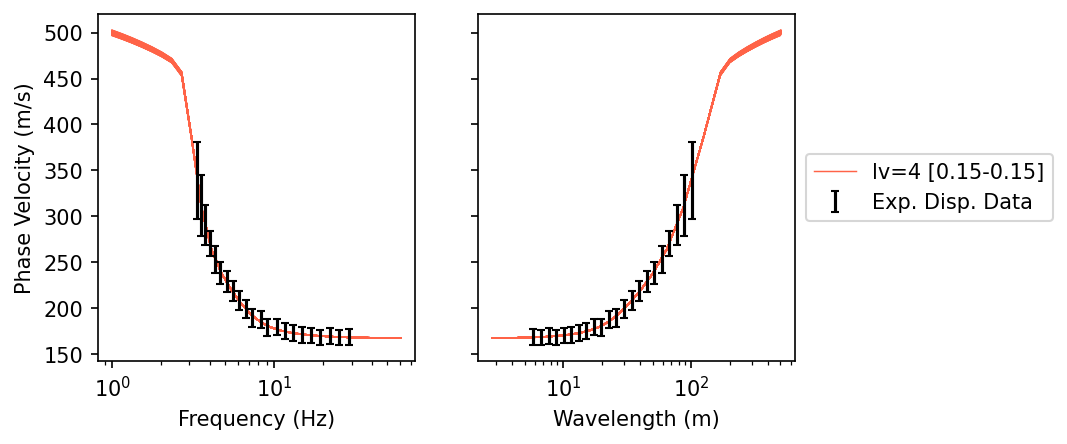

In [15]:
ndc = 100       # Number of dispersion curves to plot, may use "all".
nray = 1      # Number of Rayleigh-wave modes to plot, may use "all".
nlov = 0      # Number of Love-wave modes to plot, may use "all".

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(6,3), dpi=150)

# Plot the Theoretical Modes of Inversion Ground Models.
color_id = 0
for partype in dcs:
    for parnumber in dcs[partype]:
        best = bestseed[partype][parnumber]
        suite = dcs[partype][parnumber][best]
        label = f"{partype}={parnumber} {suite.misfit_repr(nmodels=ndc)}"
        
        color = colors[color_id]
        for dc_count, dcset in enumerate(suite):
            for mode in range(nray):
                try:
                    dc = dcset.rayleigh[mode]
                    axs[1].plot(dc.wavelength, dc.velocity, color=color, label=label, linewidth=0.7)
                    label=None
                    axs[0].plot(dc.frequency, dc.velocity, color=color, label=label, linewidth=0.7)
                except KeyError:
                    print(f"Could not find mode {mode}.")                    
            if dc_count+1 == ndc:
                break
        color_id += 1
    
# Plot the Experimental Dispersion Curve
ax = axs[0]
target.plot(ax=ax)

ax = axs[1]
target.plot(ax=ax, x="wavelength")
ax.legend(loc="center left", bbox_to_anchor=(1,0.5))
ax.set_ylabel("")

plt.show()

### Plotting Vs

[Back to top](#License-Information)

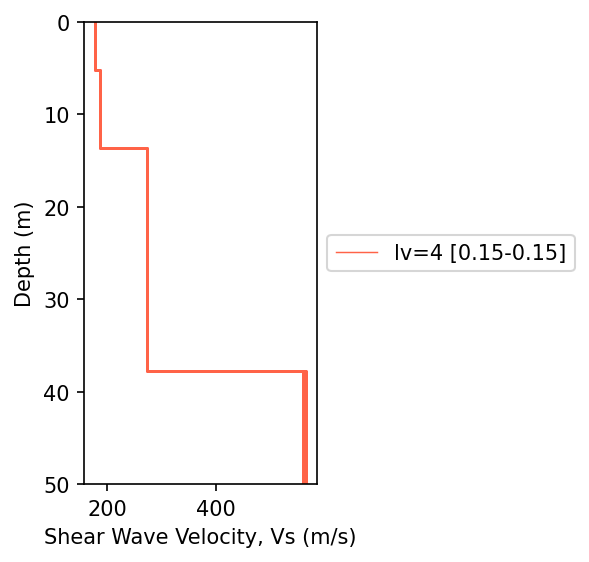

In [16]:
ngm = 100             # Number of Vs profiles to plot and consider for Vs uncertainty (see next).
plot_depth = 50     # Maximum plot depth in meters.

fig, ax = plt.subplots(figsize=(2, 4), dpi=150)
color_id = 0
all_gm = []
for partype in gms:
    for parnumber in gms[partype]:
        best = bestseed[partype][parnumber]
        suite = gms[partype][parnumber][best]    
        
        label = f"{partype}={parnumber} {suite.misfit_repr(nmodels=ngm)}"
        for gm in suite[:ngm]:
            all_gm.append(gm)
            ax.plot(gm.vs2, gm.depth, color=colors[color_id], label=label, linewidth=0.7)
            label=None
        color_id += 1
    ax.set_ylim(plot_depth, 0)
    ax.set_xlabel('Shear Wave Velocity, Vs (m/s)')
    ax.set_ylabel('Depth (m)')
    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.show()

### Plotting Vs30

[Back to top](#License-Information)

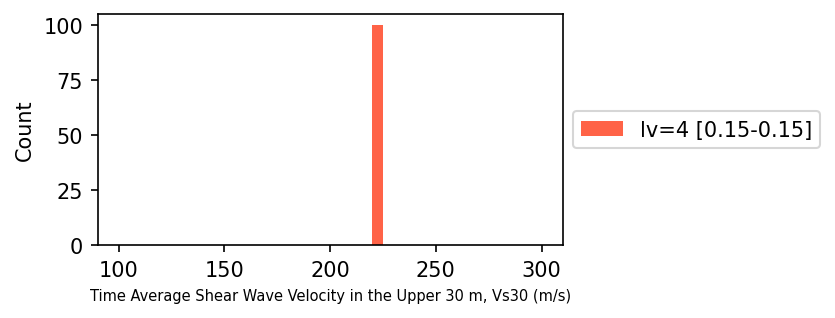

Mean Vs30: 224 m/s
Standard Deviation of Vs30: 0 m/s


In [20]:
ngm = 100          # Number of Vs profiles to plot and consider for Vs uncertainty (see next). use 1 to get Vs30
vs30_min = 100
vs30_max = 300
vs30_bin = 5

fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
color_id = 0
bins = np.arange(vs30_min, vs30_max+vs30_bin, vs30_bin)
bins_mid = bins[:-1]+0.5*vs30_bin
bottom = np.zeros_like(bins_mid)
vs30s = []
for partype in gms:
    for parnumber in gms[partype]:
        best = bestseed[partype][parnumber]
        suite = gms[partype][parnumber][best]    
        
        label = f"{partype}={parnumber} {suite.misfit_repr(nmodels=ngm)}"
        ith_vs30 = suite.vs30(nbest=ngm)
        vs30s.extend(ith_vs30)
        dcount, _ = np.histogram(ith_vs30, bins=bins)
        ax.bar(bins_mid, dcount, width=vs30_bin, bottom=bottom, color=colors[color_id], label=label)
        bottom += dcount
        color_id += 1
    ax.set_xlabel('Time Average Shear Wave Velocity in the Upper 30 m, Vs30 (m/s)', fontsize=7)
    ax.set_ylabel('Count')
    ax.legend(bbox_to_anchor=(1, 0.5), loc='center left')
plt.show()

print(f"Mean Vs30: {np.mean(vs30s):.0f} m/s")
print(f"Standard Deviation of Vs30: {np.std(vs30s, ddof=1):.0f} m/s")

### Plotting Uncertainty

[Back to top](#License-Information)

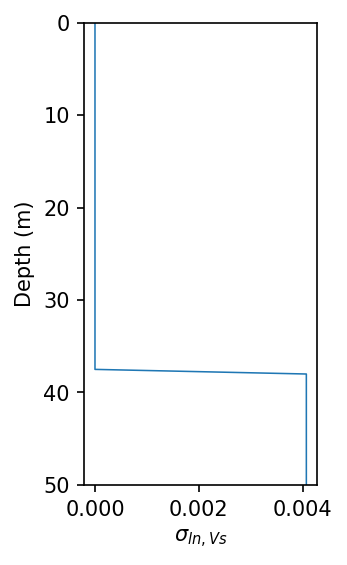

In [21]:
fig, ax = plt.subplots(figsize=(2, 4), dpi=150)
color_id = 0
all_gm_suite = swprepost.GroundModelSuite.from_list(all_gm)
ddepth, dsigmaln = all_gm_suite.sigma_ln()
ax.plot(dsigmaln, ddepth, linewidth=0.75)
ax.set_ylim(plot_depth, 0)
ax.set_xlabel(r"$\sigma_{ln,Vs}$")
ax.set_ylabel("Depth (m)")
plt.show()